In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from base64 import b64encode

import pandas as pd
import requests

from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt

# Watt Time vs. SGIP

# SGIP

In [121]:
username = 'caltech'
password = 'caltechsgip.2022'
email = 'cyeh@caltech.edu'

# register_data = dict(username=username, password=password, email=email)
# r = requests.post('https://sgipsignal.com/register', data=register_data)
# print(r.content)

In [122]:
def register(username, password, email, org):
    url = 'https://sgipsignal.com/register'
    params = {'username': username,
              'password': password,
              'email': email,
              'org': org}
    rsp = requests.post(url, json=params)
    print(rsp.text)


def get_data_sgip(starttime, endtime):
    # Authenticate
    r = requests.get('https://sgipsignal.com/login/', auth=(username, password))
    token = r.json()['token']

    headers = {
      'Authorization': f'Bearer {token}'
    }
    params = dict(
        ba='SGIP_BANC_P2',
        starttime=starttime,
        endtime=endtime,
        # version=
    )
    r = requests.get('https://sgipsignal.com/sgipmoer/', params=params, headers=headers)

    return pd.DataFrame(r.json())

# Watt Time

In [125]:
# only CAISO access is allowed
def list_of_grid_regions():
    # retrieve token for accessing data
    login_url = 'https://api2.watttime.org/v2/login'
    token = requests.get(login_url, auth=HTTPBasicAuth('rdatta', 'g_$#}MekP});')).json()['token']

    # setting up request's URL and other configs
    data_url = 'https://api2.watttime.org/v2/ba-access'
    headers = {'Authorization': 'Bearer {}'.format(token)}
    params = {'all': 'true'}

    # make get request and save JSON as text
    rsp = requests.get(data_url, headers=headers, params=params)
    soup = bs(rsp.text,"lxml")

    return soup.get_text()

for line in list_of_grid_regions().split("{"):
    if '"access": true' in line:
        print(line)

"ba": "CAISO_NORTH", "name": "California ISO Northern", "access": true, "datatype": "MOER"}, 


In [134]:
LB_TO_KG = 0.453592

def get_data_watttime(starttime, endtime):
    # retrieve token for accessing data
    login_url = 'https://api2.watttime.org/v2/login'
    token = requests.get(login_url, auth=HTTPBasicAuth('rdatta', 'g_$#}MekP});')).json()['token']

    # setting up request's URL and other configs
    data_url = 'https://api2.watttime.org/v2/data'
    headers = {'Authorization': 'Bearer {}'.format(token)}
    params = {'ba': 'CAISO_NORTH', 
            'starttime': starttime, 
            'endtime': endtime} # define to be the latest week of data

    # make get request and save JSON as text
    rsp = requests.get(data_url, headers=headers, params=params)

    df = pd.DataFrame(rsp.json())
    # convert from CO2 lbs/MWh to kg/KWh
    df['value'] *= (0.001 * LB_TO_KG)
    return df

def set_datetime_as_index(df: pd.DataFrame):
    df['point_time'] = pd.to_datetime(df['point_time'])
    df = df.set_index(df['point_time'])
    return df.drop('point_time', axis=1)

def get_combined_moer(starttime, endtime):
    df_sgip = get_data_sgip(starttime, endtime)
    df_sgip = set_datetime_as_index(df_sgip)
    df_sgip.rename(columns={'moer': 'value_sgip'}, inplace=True)

    df_watt = get_data_watttime(starttime, endtime)
    df_watt = set_datetime_as_index(df_watt)
    df_watt.rename(columns={'value': 'value_watt_time'}, inplace=True)

    return pd.concat([df_sgip, df_watt], axis=1)[['value_watt_time', 'value_sgip']].copy()

<AxesSubplot:xlabel='point_time'>

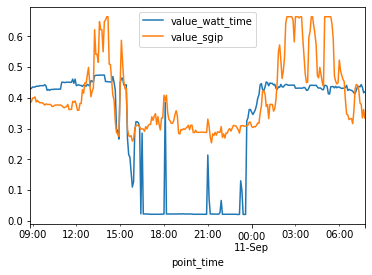

In [141]:
starttime = '2019-09-10T00:45:30-0800'
endtime = '2019-09-10T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
df.plot()

<AxesSubplot:xlabel='point_time'>

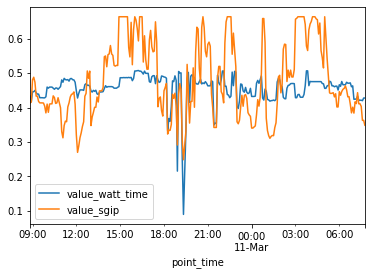

In [143]:
starttime = '2020-03-10T00:45:30-0800'
endtime = '2020-03-10T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
df.plot()

<AxesSubplot:xlabel='point_time'>

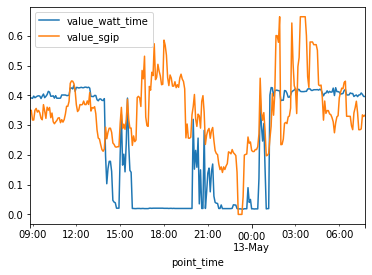

In [144]:
starttime = '2020-05-12T00:45:30-0800'
endtime = '2020-05-12T23:45:30-0800'
df = get_combined_moer(starttime, endtime)
df.plot()